<a href="https://colab.research.google.com/github/ben-wycliff/dl_final_project/blob/main/nb5_model_simplification-SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/known_images.zip

# Imports

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay,
                             classification_report)

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import (img_to_array, load_img)

# Constants

In [4]:
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = (488, 395)

# Prepare Dataset

In [5]:
# create dataframe
df = pd.read_csv("/content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset.csv")
df["labels"] = df["labels"].astype(str)
df.head(10) # all sick images are labelled 1 while normal images are labelled 2

,Unnamed: 0,images,labels
0,0,sick_272.png,1
1,1,sick_292.png,1
2,2,sick_144.png,1
3,3,sick_50.png,1
4,4,normal_95.png,0
5,5,sick_92.png,1
6,6,normal_210.png,0
7,7,normal_253.png,0
8,8,sick_12.png,1
9,9,normal_71.png,0


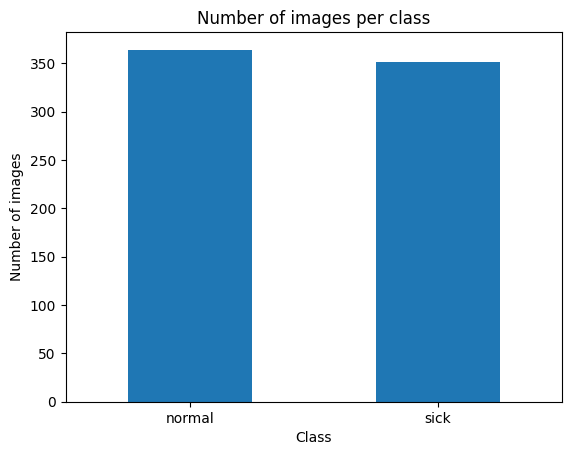

In [6]:
# From this plot we see the number of images is fairly
# distributed between the two classes
df.labels.value_counts().plot(kind="bar"); 
plt.title("Number of images per class")
plt.xticks(ticks=[0,1],labels=["normal", "sick"], rotation=0)
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.show()

In [7]:
# create dataset splits
df_train, df_eval = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_val = train_test_split(df_eval, test_size=0.33, random_state=42)

In [8]:
# subplot the partitioning results
print("\nTrain partition:\n", df_train.labels.value_counts())
print("\nTest partition:\n", df_test.labels.value_counts())
print("\nValidation partition:\n", df_val.labels.value_counts())


Train partition:
 0    253
1    247
Name: labels, dtype: int64

Test partition:
 0    75
1    69
Name: labels, dtype: int64

Validation partition:
 0    36
1    35
Name: labels, dtype: int64


In [14]:
# create data generators
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255.0,
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="./known_images",
                                                    x_col="images",
                                                    y_col="labels",
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode="binary",
                                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

val_generator = test_datagen.flow_from_dataframe(dataframe=df_val,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  class_mode="binary",
                                                 shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 500 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.


# Train the model

## Model Architecture

In [15]:
model = keras.Sequential(
    [
      layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(32, activation="relu"),
      layers.Dense(1, activation="sigmoid")
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 486, 393, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 243, 196, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 241, 194, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 120, 97, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 95, 64)       36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 47, 64)      

## Optimizer

In [16]:
# optimizer
opt = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint_filepath = './models/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  monitor='val_loss',
  save_best_only=True, 
  mode='min'
)

callback_list = [checkpoint]

## Training

In [17]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    validation_data=val_generator,
                    callbacks=callback_list)

Epoch 1/50
16/16 [==============================] - 27s 2s/step - loss: 0.6696 - accuracy: 0.5860 - val_loss: 0.6721 - val_accuracy: 0.5070
Epoch 2/50
16/16 [==============================] - 26s 2s/step - loss: 0.6305 - accuracy: 0.6040 - val_loss: 0.6116 - val_accuracy: 0.7606
Epoch 3/50
16/16 [==============================] - 26s 2s/step - loss: 0.5517 - accuracy: 0.7840 - val_loss: 0.5320 - val_accuracy: 0.6901
Epoch 4/50
16/16 [==============================] - 25s 2s/step - loss: 0.4680 - accuracy: 0.8100 - val_loss: 0.4583 - val_accuracy: 0.7606
Epoch 5/50
16/16 [==============================] - 25s 2s/step - loss: 0.3803 - accuracy: 0.8320 - val_loss: 0.4176 - val_accuracy: 0.7606
Epoch 6/50
16/16 [==============================] - 26s 2s/step - loss: 0.3866 - accuracy: 0.8400 - val_loss: 0.4379 - val_accuracy: 0.7465
Epoch 7/50
16/16 [==============================] - 26s 2s/step - loss: 0.4070 - accuracy: 0.8080 - val_loss: 0.4096 - val_accuracy: 0.7465
Epoch 8/50
16/16 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


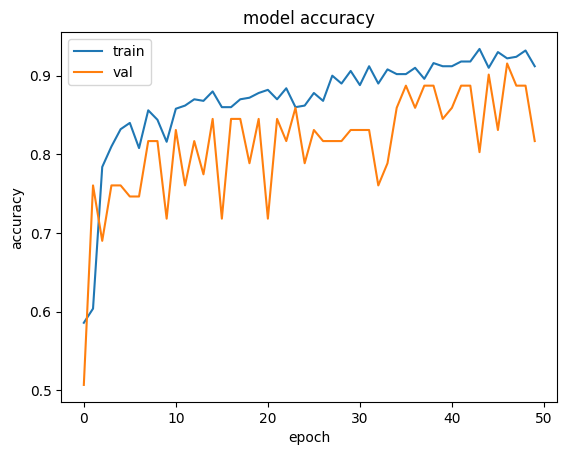

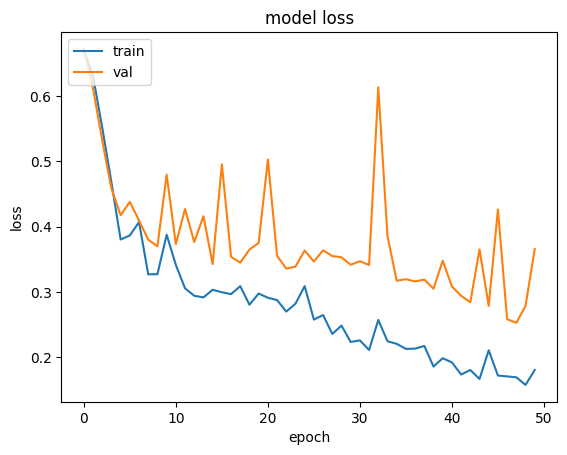

In [18]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
from keras.models import load_model
best_model = load_model("/content/models/my_best_model.epoch48-loss0.25.hdf5")

In [20]:
best_model.evaluate(test_generator)

5/5 [==============================] - 2s 398ms/step - loss: 0.1275 - accuracy: 0.9444


[0.12751905620098114, 0.9444444179534912]

In [21]:
y_true = test_generator.classes

In [22]:
y_pred = best_model.predict(test_generator)

5/5 [==============================] - 1s 216ms/step


In [23]:
def threshold_predictions(predictions, threshold=0.5):
  return [1 if i >= threshold else 0 for i in predictions]

In [24]:
y_pred = threshold_predictions(y_pred)

In [25]:
y_pred.count(0)

75

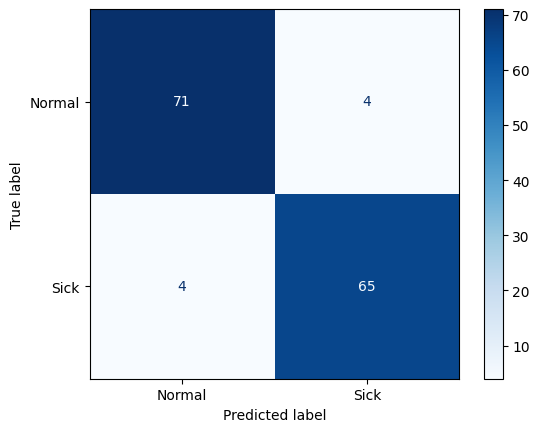

In [26]:
def plot_confusion_matrix(y_test, y_pred, labels):
  """
    y_test: true y labels
    y_pred: predicted y labels
    labels: class labels
  """
  disp = ConfusionMatrixDisplay.from_predictions(y_test,
                                                 y_pred,
                                                 display_labels=labels,
                                                 cmap="Blues")

plot_confusion_matrix( y_true, y_pred, ["Normal", "Sick"])

In [27]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        75
           1       0.94      0.94      0.94        69

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



# Test on unknown dataset

In [28]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/dataset2.zip

Archive:  /content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset2.zip
   creating: images/
  inflating: images/sick_eff0.png    
  inflating: images/sick_eff1.png    
  inflating: images/sick_eff10.png   
  inflating: images/sick_eff100.png  
  inflating: images/sick_eff101.png  
  inflating: images/sick_eff102.png  
  inflating: images/sick_eff103.png  
  inflating: images/sick_eff104.png  
  inflating: images/sick_eff105.png  
  inflating: images/sick_eff106.png  
  inflating: images/sick_eff107.png  
  inflating: images/sick_eff108.png  
  inflating: images/sick_eff109.png  
  inflating: images/sick_eff11.png   
  inflating: images/sick_eff110.png  
  inflating: images/sick_eff111.png  
  inflating: images/sick_eff12.png   
  inflating: images/sick_eff13.png   
  inflating: images/sick_eff14.png   
  inflating: images/sick_eff15.png   
  inflating: images/sick_eff16.png   
  inflating: images/sick_eff17.png   
  inflating: images/sick_eff18.png   
  inflating: imag

In [29]:
df2 = pd.read_csv("/content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset2_image_classes.csv")

In [30]:
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff2,0
3,sick_eff3,0
4,sick_eff4,0


In [31]:
df2.keys()

Index(['patient ', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')

In [32]:
df2["patient "] = df2["patient "]+".png"
df2["diagnosis (0-Normal, 1-Sick)"] = df2["diagnosis (0-Normal, 1-Sick)"].astype(str)
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0.png,0
1,sick_eff1.png,0
2,sick_eff2.png,0
3,sick_eff3.png,0
4,sick_eff4.png,0


In [33]:
dataset2_generator = test_datagen.flow_from_dataframe(dataframe=df2,
                                                      directory="./images",
                                                      x_col="patient ",
                                                      y_col="diagnosis (0-Normal, 1-Sick)",
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode="binary",
                                                      shuffle=False,
                                                      batch_size=32)

Found 224 validated image filenames belonging to 2 classes.


In [34]:
best_model.evaluate(dataset2_generator)

7/7 [==============================] - 2s 248ms/step - loss: 1.9216 - accuracy: 0.4866


[1.9216066598892212, 0.4866071343421936]

In [35]:
y_true2 = dataset2_generator.classes
y_pred2 = threshold_predictions(best_model.predict(dataset2_generator))

7/7 [==============================] - 2s 270ms/step


              precision    recall  f1-score   support

           0       0.44      0.10      0.16       112
           1       0.49      0.88      0.63       112

    accuracy                           0.49       224
   macro avg       0.47      0.49      0.40       224
weighted avg       0.47      0.49      0.40       224



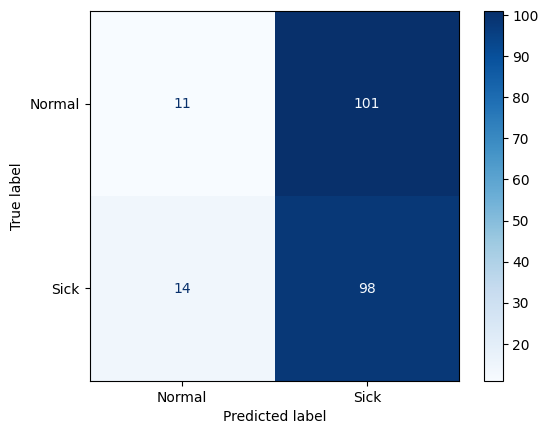

In [36]:
plot_confusion_matrix( y_true2, y_pred2, ["Normal", "Sick"])
print(classification_report(y_true2, y_pred2))

# Evaluate on unknown images

In [37]:
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/unknown_images.zip

Archive:  /content/drive/MyDrive/Personal/Computer Vision/dl_final_project/unknown_images.zip
   creating: unknown_images/
  inflating: unknown_images/1.png    
  inflating: unknown_images/10.png   
  inflating: unknown_images/11.png   
  inflating: unknown_images/12.png   
  inflating: unknown_images/13.png   
  inflating: unknown_images/14.png   
  inflating: unknown_images/15.png   
  inflating: unknown_images/16.png   
  inflating: unknown_images/17.png   
  inflating: unknown_images/18.png   
  inflating: unknown_images/19.png   
  inflating: unknown_images/2.png    
  inflating: unknown_images/20.png   
  inflating: unknown_images/21.png   
  inflating: unknown_images/22.png   
  inflating: unknown_images/23.png   
  inflating: unknown_images/24.png   
  inflating: unknown_images/25.png   
  inflating: unknown_images/26.png   
  inflating: unknown_images/27.png   
  inflating: unknown_images/28.png   
  inflating: unknown_images/29.png   
  inflating: unknown_images/3.png    
  i

In [38]:
# image reader
def read_image(path):
  img = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_reshaped = np.expand_dims(img, axis=0)
  return test_datagen.flow(img_reshaped, batch_size=1)[0]

In [39]:
unknown_images = os.listdir("./unknown_images")

In [40]:
read_image(os.path.join("./unknown_images", unknown_images[0]))
# predict classes for unknown images
image_names = []
image_predictions = []
for img_name in unknown_images:
  img = read_image(os.path.join("./unknown_images", img_name))
  prediction = threshold_predictions(best_model.predict(img)[0])[0]
  image_names.append(img_name) 
  image_predictions.append(prediction) 
  print(f"{img_name} - {prediction}")

1/1 [==============================] - 0s 315ms/step
20.png - 1
1/1 [==============================] - 0s 28ms/step
9.png - 0
1/1 [==============================] - 0s 23ms/step
35.png - 0
1/1 [==============================] - 0s 25ms/step
22.png - 1
1/1 [==============================] - 0s 25ms/step
10.png - 1
1/1 [==============================] - 0s 25ms/step
7.png - 0
1/1 [==============================] - 0s 22ms/step
29.png - 0
1/1 [==============================] - 0s 22ms/step
27.png - 1
1/1 [==============================] - 0s 24ms/step
4.png - 1
1/1 [==============================] - 0s 29ms/step
12.png - 1
1/1 [==============================] - 0s 27ms/step
46.png - 1
1/1 [==============================] - 0s 24ms/step
24.png - 0
1/1 [==============================] - 0s 27ms/step
47.png - 0
1/1 [==============================] - 0s 25ms/step
40.png - 1
1/1 [==============================] - 0s 23ms/step
39.png - 0
1/1 [==============================] - 0s 22ms/step
17.pn

In [41]:
image_predictions.count(0)

27

In [42]:
image_predictions.count(1)

23

In [43]:
image_prediction_classes=["normal" if i == 0 else "sick" for i in image_predictions]

In [44]:
unknown_preds_df = pd.DataFrame({"image":image_names,
                                 "diagnosis": image_prediction_classes })

In [45]:
unknown_preds_df.head()

,image,diagnosis
0,20.png,sick
1,9.png,normal
2,35.png,normal
3,22.png,sick
4,10.png,sick


In [49]:
# export predictions
unknown_preds_df.to_csv("nb5-unknown-preds.csv")

In [50]:
!cp -r /content/nb5-experiments /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/models
!cp -r /content/nb5-unknown-preds.csv /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/models